## ch11 XGBoost Hyperparameters
- https://github.com/mattharrison/effective_xgboost_book/blob/main/xgbcode.ipynb

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2023.7.31</div>
<div style="text-align: right"> Last update: 2023.7.31</div>

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

새롭게 라이브러리를 로드 하자.

In [2]:
import dtreeviz
from feature_engine import encoding, imputation
import numpy as np
import pandas as pd
from sklearn import base, compose, datasets, ensemble, \
    metrics, model_selection, pipeline, preprocessing, tree
import scikitplot
import xgboost as xgb
import yellowbrick.model_selection as ms
from yellowbrick import classifier

import urllib
import zipfile

import xg_helpers as xhelp
from xg_helpers import my_dot_export

In [3]:
url = 'https://github.com/mattharrison/datasets/raw/master/data/'\
'kaggle-survey-2018.zip'
fname = 'kaggle-survey-2018.zip'
member_name = 'multipleChoiceResponses.csv'

In [4]:
raw = xhelp.extract_zip(url, fname, member_name)
## Create raw X and raw y
kag_X, kag_y = xhelp.get_rawX_y(raw, 'Q6')

In [5]:
## Split data
kag_X_train, kag_X_test, kag_y_train, kag_y_test = \
model_selection.train_test_split(
kag_X, kag_y, test_size=.3, random_state=42, stratify=kag_y)

In [6]:
## Transform X with pipeline
X_train = xhelp.kag_pl.fit_transform(kag_X_train)
X_test = xhelp.kag_pl.transform(kag_X_test)
## Transform y with label encoder
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(kag_y_train)
y_train = label_encoder.transform(kag_y_train)
y_test = label_encoder.transform(kag_y_test)
# Combined Data for cross validation/etc
X = pd.concat([X_train, X_test], axis='index')
y = pd.Series([*y_train, *y_test], index=X.index)

In [7]:
X.head()

,age,education,years_exp,compensation,python,r,sql,Q1_Male,Q1_Female,Q1_Prefer not to say,Q1_Prefer to self-describe,Q3_United States of America,Q3_India,Q3_China,major_cs,major_other,major_eng,major_stat
587,25,18.0,4.0,0,1,0,1,1,0,0,0,0,1,0,0,1,0,0
3065,22,16.0,1.0,10000,1,0,0,1,0,0,0,0,1,0,1,0,0,0
8435,22,18.0,1.0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0
3110,40,20.0,3.0,125000,1,0,1,0,1,0,0,1,0,0,0,1,0,0
16372,45,12.0,5.0,100000,1,0,1,1,0,0,0,1,0,0,0,1,0,0


In [8]:
y.head()

587      1
3065     0
8435     0
3110     0
16372    1
dtype: int64

### 11.1 Hyperparameters

하이퍼파라미터는 다음과 같은 형태로 분류할 수 있다.
- tree creation,
- sampling, 
- categorical data, 
- ensembling, 
- regularization, 
- imbalanced data

tree 하이퍼파라미터는 다음과 같다.  
- max_depth=6 : 트리 깊이. 얼마나 많은 피처 상호작용을 할 수 있는지입니다. 클수록 더 복잡합니다(과적합 가능성이 높습니다). 각 레벨은 시간을 두 배로 늘립니다. 범위 [0, ∞].  
- max_leaves=0 : 트리의 잎 수입니다. 숫자가 클수록 더 복잡합니다. (Not tree_method='exact'에서 지원되지 않음). 범위 [0, ∞].  
- min_child_weight=1 : 자식에게 필요한 헤시안(무게)의 최소 합계입니다. 값이 클수록 값이 클수록 더 보수적입니다. 범위 [0,∞].  
- grow_policy="depthwise"' - (tree_method가 'hist', 'approx' 또는 'gpu_hist' 일때만 진행. 루트에 가장 가까운 노드를 분할합니다. "lossguide"(최대_뎁스=0으로 설정)로 설정하면 LightGBM 동작을 모방합니다.  
- tree_method="auto" : 히스토그램 버킷링을 사용하고 성능을 높이려면 "hist"를 사용합니다.
  - `auto`로 설정하면
    - 'exact' for small data
    – 'approx' for larger data
    – 'hist' for histograms (limit bins with max_bins (default 256))

sampling 하이퍼 파라미터. 이 파라미터들은 순차적으로 동작한다.  
- tree -> level -> 노드 순이다.  
예를 들어 colsample_bytree, colsample_bylevel 및 colsample_bynode가 모두 .5인 경우 트리는 원본 열의 12.5%(.5 * .5 * .5) 만 보게 됩니다.   

- colsample_bytree=1 : 각 트리에서 컬럼을 서브 샘플링합니다. 범위 (0,1]. [.5, 1] 를 권장
- colsample_bylevel=1 : 각 레벨에서 컬럼을 서브 샘플링합니다(트리 컬럼 colsample_bytree에서). 범위 (0,1]. [.5, 1]를 권장
- colsample_bynode=1 : 각 노드 분할에서 컬럼을 서브 샘플링합니다(트리 컬럼 colsample_bytree에서). 범위 (0,1]. [.5, 1]를 권장
- subsample=1 : 각 부스팅 라운드 전 학습 데이터(rows)의 샘플 비율. 범위 (0,1]. 더 보수적으로 만들려면 낮게 설정합니다. (1.0이 아닌 경우 모델은 확률적 경사 하강을 수행합니다. 즉, 모델에 약간의 무작위성이 있습니다.) [.5, 1] 범위를 권장.
- sampling_method='uniform' : 샘플링 방법. uniform 확률의 경우 'uniform'. gradient_based 샘플은 정규화된 그라데이션 절대값에 비례합니다(tree_method="gpu_hist"에서만 지원).



카테고리 데이터 관련 하이퍼 파라미터 : `enable_categorical=True`로 설정해야하고 판다스에서 카테고리로 설정해야 한다. `.astype('category')`

- max_cat_to_onehot=4 : 카테고리 피처에 원핫 인코딩을 사용하기 위한 상한 임계값입니다. 카테고리 수가 이 값보다 작을 때 원핫 인코딩이 사용됩니다.

- max_cat_threshold=64 : 각 분할에 대해 고려할 최대 카테고리 수입니다.

앙상블 하이퍼 파라미터 : 어떻게 하위 트리가 생성되는지를 제어한다.   
- n_estimators=100 : 트리 수입니다. 클수록 더 복잡합니다. 기본값은 100입니다. 과적합을 방지하려면 조기 중지 라운드를 사용합니다. 조기 중지 라운드를 사용하는 경우 튜닝할 필요가 없습니다.

- 조기 중지 라운드 = 없음 : n 라운드 후에도 평가 지표 점수가 개선되지 않으면 새 트리 생성을 중지합니다. 범위 [1,∞] 

- eval_metric : 조기 중지를 평가하기 위한 검증 데이터를 평가하기 위한 메트릭입니다.
  - 분류 관련 메트릭
    - `logloss`(디펄트), `auc`

- objective : 학습에서 최적화 하기 위한 objective
  - 분류 관련 메트릭
    - `binary:logistic`(디펄트, 출력이 확률이다)
    - `multi:softmax`(멀티클래스 objective)

Regularization 하이퍼파라미터 : 모델의 전반적인 복잡도를 제어
- learning_rate = .3 : 매 부스팅 라운드마다 가중치를 곱해서 보수적으로 접근한다. 작을 수록 보수적 범위 (0, 1], 이 값을 낮추고 n_estimators를 늘려서 사용하기도 한다.  
- gamma = 0 / min_split_loss : L0 정규화. 주어진 값을 충족하지 않는 분할을 제거하기 위해 트리를 가지치기합니다. 전역 정규화. 분할에 필요한 최소 손실입니다. 클수록 보수적입니다. 범위 [0, ∞), 기본값 0 - 정규화 없음. 권장 검색은 (0, 1, 10, 100, 1000...)입니다.  
- reg_alpha=0 : L1/ridge regularization. (Mean of weights). Increase to be more
conservative. Range [0, ∞)
- reg_lambda=0 : L2 regularization. (Root of squared weights). Increase to be more
conservative. Range [0, ∞)

Imbalanced data hyperparameters  
- scale_pos_weight=1 : 불균형한 클래스의 경우 (negative 카운트) / (positive 카운트)를 고려합니다. 범위 (0, 큰 수)
- max_delta_step=0 : 리프 출력의 최대 델타 스텝. 불균형한 클래스에 도움이 될 수 있습니다. 범위 [0, ∞)
- eval_metric 메트릭에 'auc' 또는 'aucpr' 사용(분류 기본값인 'logless' 대신)


### 11.2 Examining Hyperparameters

모델의 하이퍼파라미터를 확인해보자.

In [9]:
xg = xgb.XGBClassifier()
xg.fit(X_train, y_train)
xg.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

### 11.3 Tuning Hyperparameters
우선 하나만 튜닝해본다.
gamma 만 고려해보자. 감마는 트리의 프루너로 보면된다. 값이 클수록 모델이 단순해진다.

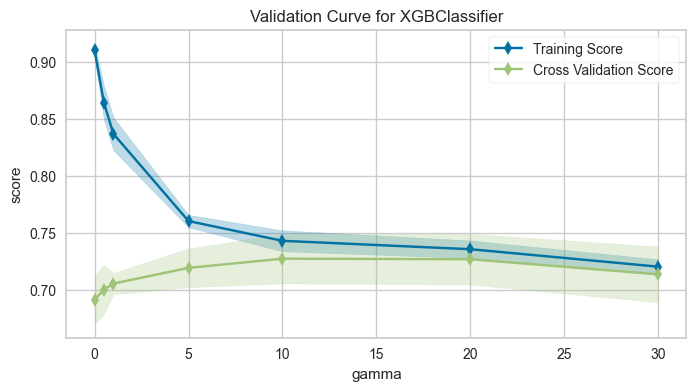

ValidationCurve(ax=<Axes: title={'center': 'Validation Curve for XGBClassifier'}, xlabel='gamma', ylabel='score'>,
                estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric=None, feature_types=None,
                                        gamma=None, gpu_id=No...
                                        learning_rate=None, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
                                        max_delta_step=None, max_depth=None,
                                        max_leaves=None, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        n_estimators=100, n_jobs=None,
                                        num_parallel_tree=None, predictor=None,
                                        random_state=None, ...),
                n_jobs=-1, param_name='gamma',
                param_range=array([ 0. ,  0.5,  1. ,  5. , 10. , 20. , 30. ]))

In [10]:
fig, ax = plt.subplots(figsize=(8, 4))
ms.validation_curve(xgb.XGBClassifier(), X_train, y_train, param_name='gamma',
param_range=[0, .5, 1,5,10, 20, 30], n_jobs=-1, ax=ax)

- 10 ~ 20 사이가 좋아보임

### 11.4 Intuitive Understanding of Learning Rate

모델의 정확도를 극대화할 수 있는 적절한 균형을 찾아야 합니다. 그 최적점이 어디인지 찾으려면 실험을 해봐야 합니다. 골프에서는 다양한 기술을 실험하고 스윙과 그립을 조정하며 연습이 필요하지만 결국에는 홀인원을 기록할 수 있는 완벽한 조합을 찾을 수 있습니다.

두 개의 깊이 레이어가 있는 모델로 돌아가서 잎의 값을 살펴봅시다. 노드의 값을 살펴보겠습니다.

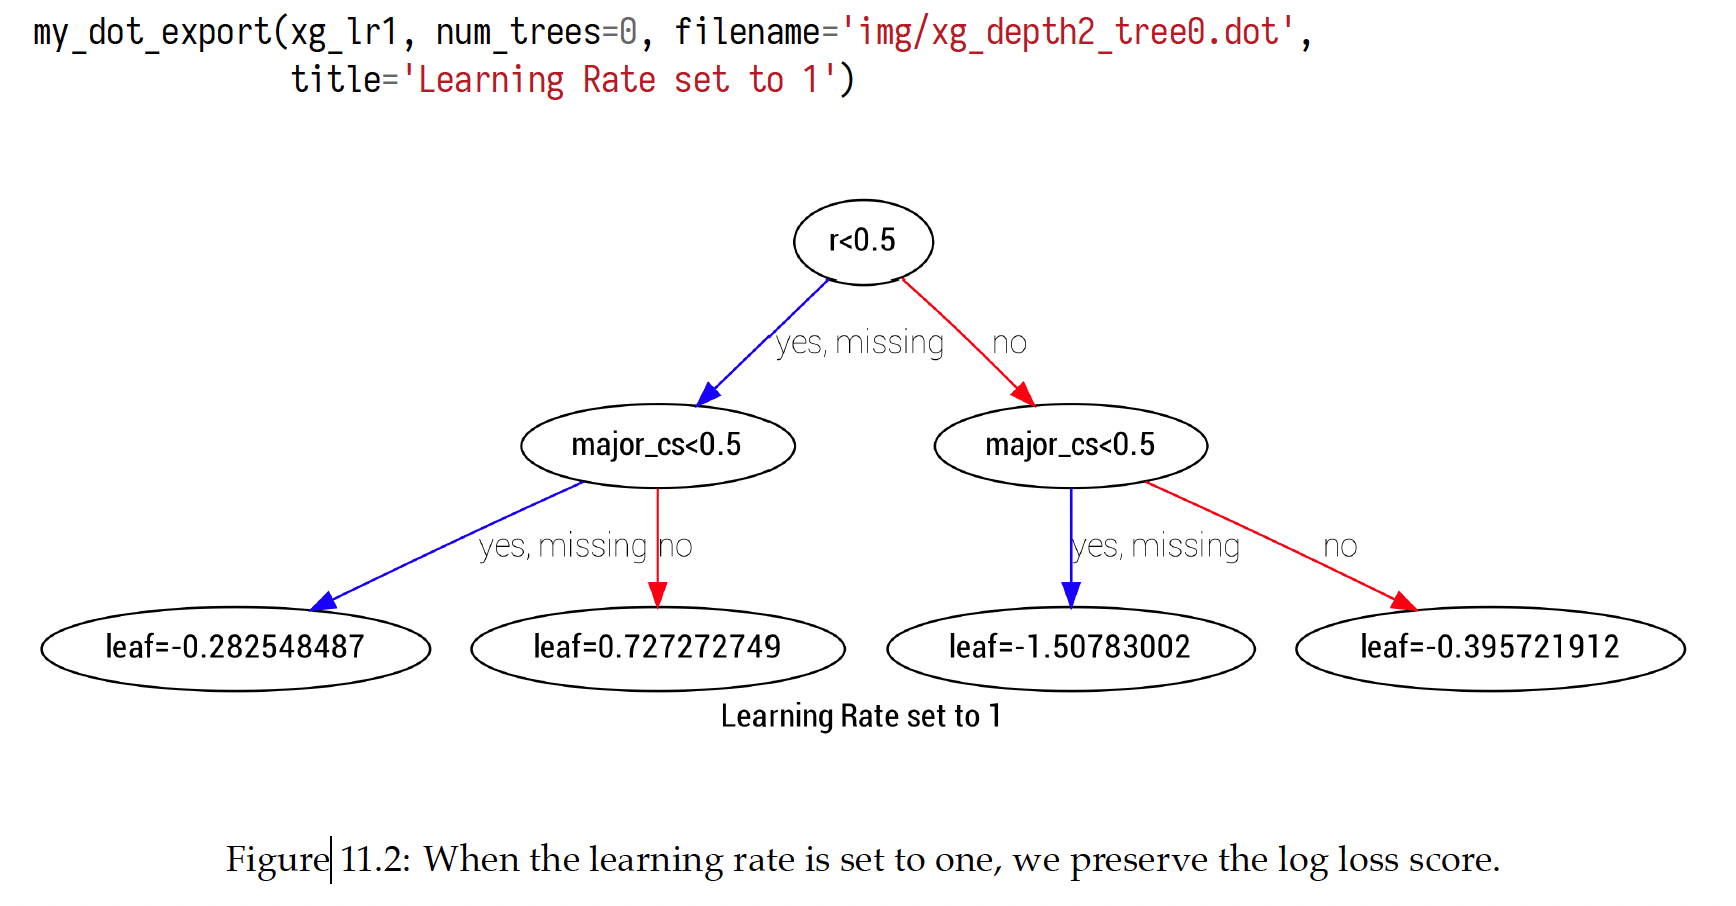

이제 learning rate를 낮춰보자.

In [11]:
xg_lr001 = xgb.XGBClassifier(learning_rate = 0.001, max_depth = 2)
xg_lr001.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [12]:
my_dot_export(xg_lr001, num_trees=0, filename='xg_depth2_tree0_lr001.dot',
title='Learning Rate set to .001')


(process:26076): Pango-WARNING **: 09:03:34.075: couldn't load font "Roboto Condensed Not-Rotated 14", modified variant/weight/stretch as fallback, expect ugly output.


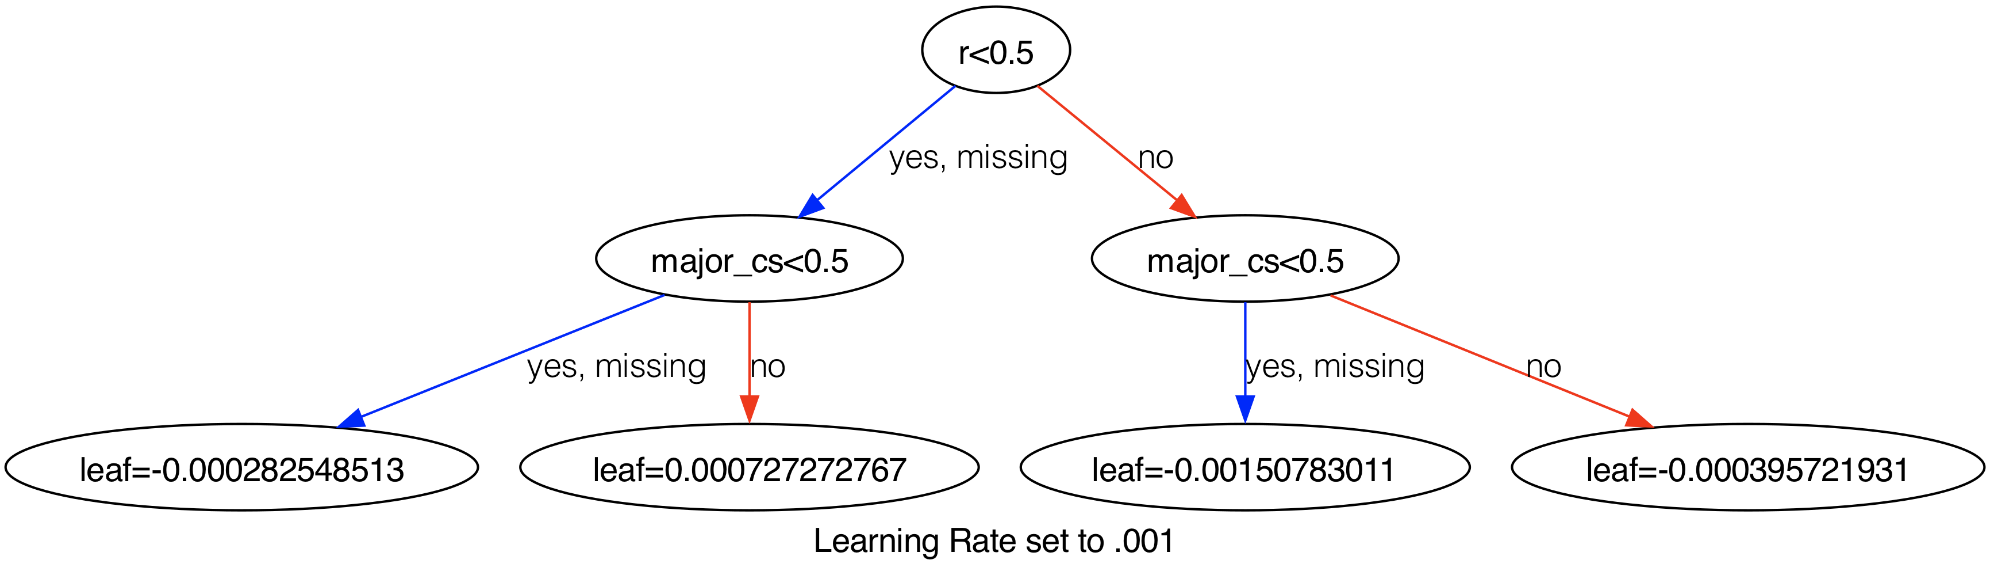

학습률이 잎의 값을 가져와서 감소한 것을 볼 수 있습니다. 양수 값은 여전히 양수 레이블을 향해 이동하지만 그 속도는 느려집니다. 학습률을 1보다 큰 값으로 설정할 수도 있지만 실제로는 의미가 없습니다. 

**(중요) learning_rate 튜닝에 대한 저의 제안 (단계별 튜닝을 보여줄 때 볼 수 있듯이)은 마지막으로 튜닝하는 것입니다.  
이것을 조기 정지 및 많은 수의 트리와 결합하십시오.   
조기 정지가 효과가 없다면 트리 수를 늘리세요(모델이 계속 개선되고 있다는 의미입니다).**

### 11.5 Grid Search

하나의 하이퍼파라미터를 보정하는 데는 시간이 걸리며, 여러 개의 하이퍼파라미터가 있으며, 그중 일부는 다른 하이퍼파라미터와 상호 작용합니다. 어떤 조합이 가장 좋은지 어떻게 알 수 있을까요? 다양한 조합을 시도하고 어떤 값이 가장 좋은 성능을 내는지 탐색할 수 있습니다.

scikit-learn의 GridSerachCV 클래스가 이 작업을 수행합니다. 이 클래스에 각 하이퍼파라미터의 잠재적 값에 대한 하이퍼파라미터 매핑을 제공해야 합니다. 이 클래스는 모든 조합을 반복하여 최적의 조합을 추적합니다. 불균형한 데이터가 있거나 다른 지표에 맞게 최적화해야 하는 경우 점수 매개변수를 설정할 수도 있습니다.

그리드 검색에 주의하세요. XGBoost에서 그리드 검색을 실행하면 모든 하이퍼파라미터 조합을 실행하는 데 시간이 오래 걸릴 수 있으므로 계산 비용이 많이 들 수 있습니다. 또한 테스트할 하이퍼파라미터의 수와 후보로 사용할 값을 결정하는 것도 어려울 수 있습니다.

나중에 모델 튜닝을 위해 그리드 검색보다 선호하는 다른 방법을 보여드리겠습니다. 아래 예제는 제 컴퓨터에서 빠르게 실행되지만 그렇게 많은 조합을 테스트하지는 않습니다. 하이퍼파라미터에 10개의 옵션이 있다고 상상해 보십시오(무작위_상태는 무시). 옵션이 있다면 1,000,000개의 테스트를 실행해야 할 것입니다.

In [13]:
from sklearn import model_selection

params = {'reg_lambda': [0],  # No effect
          'learning_rate': [.1, .3], # makes each boost more conservative 
          'subsample': [.7, 1],
          'max_depth': [2, 3],
          'random_state': [42],
          'n_jobs': [-1],
          'n_estimators': [200]}

In [14]:
xgb2 = xgb.XGBClassifier(early_stopping_rounds = 5)
cv = (model_selection.GridSearchCV(xgb2, params, cv = 3, n_jobs=-1)
      .fit(X_train, y_train,
           eval_set = [(X_test, y_test)],
           verbose = 50
           )
      )

[0]	validation_0-logloss:0.67559
[0]	validation_0-logloss:0.67638
[0]	validation_0-logloss:0.67565
[50]	validation_0-logloss:0.52789
[50]	validation_0-logloss:0.52479
[76]	validation_0-logloss:0.52156
[75]	validation_0-logloss:0.51643
[0]	validation_0-logloss:0.67687
[0]	validation_0-logloss:0.67500
[50]	validation_0-logloss:0.51775
[0]	validation_0-logloss:0.67345
[0]	validation_0-logloss:0.67220
[50]	validation_0-logloss:0.52101
[0]	validation_0-logloss:0.67159
[0]	validation_0-logloss:0.67246
[50]	validation_0-logloss:0.52412
[67]	validation_0-logloss:0.51397
[100]	validation_0-logloss:0.50297
[0]	validation_0-logloss:0.67214
[0]	validation_0-logloss:0.67504
[50]	validation_0-logloss:0.51197
[52]	validation_0-logloss:0.51103
[100]	validation_0-logloss:0.51087
[50]	validation_0-logloss:0.52950
[50]	validation_0-logloss:0.51054
[137]	validation_0-logloss:0.50025
[122]	validation_0-logloss:0.50820
[50]	validation_0-logloss:0.51417
[0]	validation_0-logloss:0.64632
[0]	validation_0-loglo

In [15]:
cv.best_params_

{'learning_rate': 0.3,
 'max_depth': 2,
 'n_estimators': 200,
 'n_jobs': -1,
 'random_state': 42,
 'reg_lambda': 0,
 'subsample': 1}

In [16]:
params = {'learning_rate': 0.3,
'max_depth': 2,
'n_estimators': 200,
'n_jobs': -1,
'random_state': 42,
'reg_lambda': 0,
'subsample': 1
}

xgb_grid = xgb.XGBClassifier(**params, early_stopping_rounds=50)
xgb_grid.fit(X_train, y_train, eval_set=[(X_train, y_train),
(X_test, y_test)],
verbose=10
)

[0]	validation_0-logloss:0.64709	validation_1-logloss:0.64544
[10]	validation_0-logloss:0.54430	validation_1-logloss:0.53771
[20]	validation_0-logloss:0.52311	validation_1-logloss:0.51780


[30]	validation_0-logloss:0.51253	validation_1-logloss:0.51011
[40]	validation_0-logloss:0.50731	validation_1-logloss:0.50763
[50]	validation_0-logloss:0.50150	validation_1-logloss:0.50626
[60]	validation_0-logloss:0.49832	validation_1-logloss:0.50483
[70]	validation_0-logloss:0.49528	validation_1-logloss:0.50508
[80]	validation_0-logloss:0.49255	validation_1-logloss:0.50703
[90]	validation_0-logloss:0.48966	validation_1-logloss:0.50807
[100]	validation_0-logloss:0.48718	validation_1-logloss:0.50778
[110]	validation_0-logloss:0.48625	validation_1-logloss:0.50810
[111]	validation_0-logloss:0.48600	validation_1-logloss:0.50789


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

이제 성능 비교를 하기위해 디펄트 모델을 구현해보자.

In [17]:
xgb_def = xgb.XGBClassifier(early_stopping_rounds=50)
xgb_def.fit(X_train, y_train, eval_set=[(X_train, y_train),
(X_test, y_test)],
verbose=10
)

[0]	validation_0-logloss:0.61534	validation_1-logloss:0.61775
[10]	validation_0-logloss:0.45062	validation_1-logloss:0.50430
[20]	validation_0-logloss:0.40872	validation_1-logloss:0.50839
[30]	validation_0-logloss:0.37945	validation_1-logloss:0.51352
[40]	validation_0-logloss:0.35009	validation_1-logloss:0.52234
[50]	validation_0-logloss:0.33692	validation_1-logloss:0.52726
[60]	validation_0-logloss:0.32142	validation_1-logloss:0.53397
[61]	validation_0-logloss:0.32072	validation_1-logloss:0.53429


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [18]:
xgb_def.score(X_test, y_test), xgb_grid.score(X_test, y_test)

(0.7558011049723757, 0.7524861878453039)

이상하게도 기본 모델이 약간 더 나은 것 같습니다. 이것은 주의가 필요한 경우입니다. 

그리드 검색은 하이퍼파라미터를 찾기 위해 3배 교차 검증을 수행했지만 최종 점수는 단일 홀드아웃 세트에 대해 계산되었습니다. K배 교차 검증(그리드 검색의 경우 k는 3)은 데이터 집합을 K배 또는 그룹으로 분할합니다.

그런 다음 모델을 테스트할 폴드를 예약하고 다른 데이터에 대해 모델을 훈련합니다. 각 폴드에 대해 이 과정을 반복합니다. 마지막으로 결과를 평균화하여 보다 정확한 예측을 생성합니다. 이 방법은 모델이 실제 환경에서 어떻게 작동하는지 더 잘 이해할 수 있는 좋은 방법입니다.

k-폴드 유효성 검사를 수행하면 모델에 .fit을 호출하고 .score를 호출하는 것과는 다른 결과를 얻을 수 있습니다. 그리드 검색 외부에서 k-fold를 실행하려면, scikit-learn의 cross_val_score 함수를 사용할 수 있습니다. 아래에서는 교차 검증을 실행합니다.

In [19]:
result_default = model_selection.cross_val_score(
    xgb.XGBClassifier(),
    X = X,
    y = y,
    cv=4
)

In [20]:
result_default

array([0.71352785, 0.72413793, 0.69496021, 0.74501992])

In [21]:
result_default.mean()

0.7194114787534214

In [22]:
result_grid = model_selection.cross_val_score(
    xgb.XGBClassifier(**params),
    X = X,
    y = y,
    cv=4
)

In [23]:
result_grid

array([0.74137931, 0.74137931, 0.74801061, 0.73572377])

In [24]:
result_grid.mean()

0.7416232505873941